# Coupling Multiple Groundwater Flow Models

This notebook takes the FloPy website quickstart version of a simple MODFLOW 6 groundwater flow model, split the model into two, and connect the models using a GWF-GWF Exchange. 

## Run the Single-Model Quickstart Example

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing solution package ims_-1...
  writing model mymodel...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package npf...
    writing package chd_0...
INFORMATION: maxbound in ('gwf6', 'chd', 'dimensions') changed to 2 based on size of stress_period_data
    writing package oc...
FloPy is using the following executable to run the model: ../../../../../../bin/mac/mf6
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                   VERSION 6.5.0 Release Candidate 12/09/2022
                               ***DEVELOP MODE***

        MODFLOW 6 compiled Jun 14 2023 15:20:13 with GCC version 12.2.0

This software is preliminary or provisional and is subject to 
revision. It is being provided to meet the need for timely best 
science. The software has not received final approval by the U

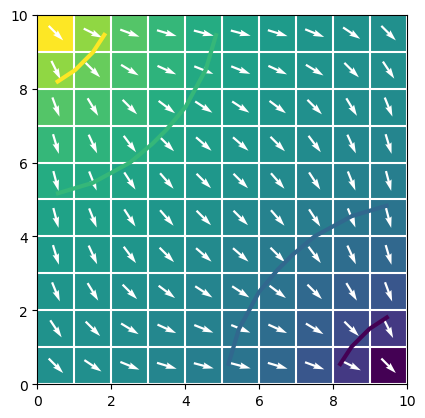

In [1]:
import flopy
ws = './quickstart1'
name = 'mymodel'
sim = flopy.mf6.MFSimulation(sim_name=name, sim_ws=ws, exe_name='mf6')
tdis = flopy.mf6.ModflowTdis(sim)
ims = flopy.mf6.ModflowIms(sim)
gwf = flopy.mf6.ModflowGwf(sim, modelname=name, save_flows=True)
dis = flopy.mf6.ModflowGwfdis(gwf, nrow=10, ncol=10)
ic = flopy.mf6.ModflowGwfic(gwf)
npf = flopy.mf6.ModflowGwfnpf(gwf, save_specific_discharge=True)
chd = flopy.mf6.ModflowGwfchd(gwf, stress_period_data=[[(0, 0, 0), 1.],
                                                       [(0, 9, 9), 0.]])
budget_file = name + '.bud'
head_file = name + '.hds'
oc = flopy.mf6.ModflowGwfoc(gwf,
                            budget_filerecord=budget_file,
                            head_filerecord=head_file,
                            saverecord=[('HEAD', 'ALL'), ('BUDGET', 'ALL')])
sim.write_simulation()
sim.run_simulation()

head = gwf.output.head().get_data()
bud = gwf.output.budget()

spdis = bud.get_data(text='DATA-SPDIS')[0]
qx, qy, qz = flopy.utils.postprocessing.get_specific_discharge(spdis, gwf)
pmv = flopy.plot.PlotMapView(gwf)
pmv.plot_array(head)
pmv.plot_grid(colors='white')
pmv.contour_array(head, levels=[.2, .4, .6, .8], linewidths=3.)
pmv.plot_vector(qx, qy, normalize=True, color="white")

## Split the Model into Two Disconnected Models

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing solution package ims_-1...
  writing model left...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package npf...
    writing package chd_0...
INFORMATION: maxbound in ('gwf6', 'chd', 'dimensions') changed to 1 based on size of stress_period_data
    writing package oc...
  writing model right...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package npf...
    writing package chd_0...
INFORMATION: maxbound in ('gwf6', 'chd', 'dimensions') changed to 1 based on size of stress_period_data
    writing package oc...
FloPy is using the following executable to run the model: ../../../../../../bin/mac/mf6
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                   VERSION 6.5.0 Release Candidate 12/09/2022
                      

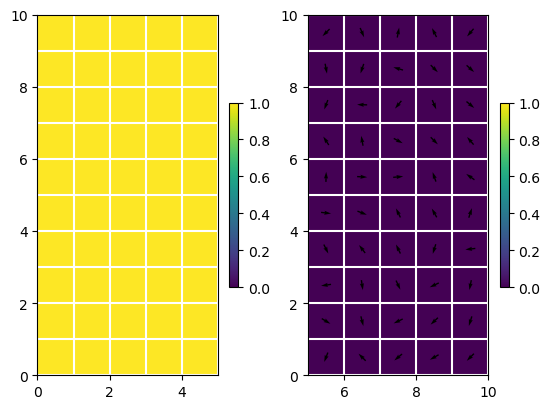

In [2]:
ws = './quickstart2'
name = 'mymodel'
sim = flopy.mf6.MFSimulation(sim_name=name, sim_ws=ws, exe_name='mf6')
tdis = flopy.mf6.ModflowTdis(sim)
ims = flopy.mf6.ModflowIms(sim, inner_dvclose=1.e-8)

# Left Model
name = "left"
nlay = 1
nrow = 10
ncol = 5
gwf = flopy.mf6.ModflowGwf(sim, modelname=name, save_flows=True)
dis = flopy.mf6.ModflowGwfdis(gwf, nrow=nrow, ncol=ncol)
ic = flopy.mf6.ModflowGwfic(gwf)
npf = flopy.mf6.ModflowGwfnpf(gwf, save_specific_discharge=True)
chd = flopy.mf6.ModflowGwfchd(gwf, stress_period_data=[[(0, 0, 0), 1.]],)
budget_file = name + '.bud'
head_file = name + '.hds'
oc = flopy.mf6.ModflowGwfoc(gwf,
                            budget_filerecord=budget_file,
                            head_filerecord=head_file,
                            saverecord=[('HEAD', 'ALL'), ('BUDGET', 'ALL')])
gwf_left = gwf

# Right Model
name = "right"
nlay = 1
nrow = 10
ncol = 5
gwf = flopy.mf6.ModflowGwf(sim, modelname=name, save_flows=True)
dis = flopy.mf6.ModflowGwfdis(gwf, nrow=nrow, ncol=ncol, xorigin=5)
ic = flopy.mf6.ModflowGwfic(gwf)
npf = flopy.mf6.ModflowGwfnpf(gwf, save_specific_discharge=True)
chd = flopy.mf6.ModflowGwfchd(gwf, stress_period_data=[[(0, nrow - 1, ncol - 1), 0.]])
budget_file = name + '.bud'
head_file = name + '.hds'
oc = flopy.mf6.ModflowGwfoc(gwf,
                            budget_filerecord=budget_file,
                            head_filerecord=head_file,
                            saverecord=[('HEAD', 'ALL'), ('BUDGET', 'ALL')])
gwf_right = gwf


sim.write_simulation()
sim.run_simulation()

import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 2) 
for iplot, gwf in enumerate([gwf_left, gwf_right]):
    ax = axes[iplot]
    ax.set_aspect("equal")
    head = gwf.output.head().get_data()
    bud = gwf.output.budget()
    spdis = bud.get_data(text='DATA-SPDIS')[0]
    qx, qy, qz = flopy.utils.postprocessing.get_specific_discharge(spdis, gwf)

    pmv = flopy.plot.PlotMapView(gwf, ax=ax)
    c = pmv.plot_array(head, vmin=0, vmax=1)
    pmv.plot_grid(colors='white')
    pmv.contour_array(head, levels=[.2, .4, .6, .8], linewidths=3.)
    pmv.plot_vector(qx, qy, normalize=True, color="black")
    plt.colorbar(c, shrink=0.5)

## Connect the Models using a GWF-GWF Exchange

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing solution package ims_-1...
  writing package mymodel.gwfgwf...
  writing model left...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package npf...
    writing package chd_0...
INFORMATION: maxbound in ('gwf6', 'chd', 'dimensions') changed to 1 based on size of stress_period_data
    writing package oc...
  writing model right...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package npf...
    writing package chd_0...
INFORMATION: maxbound in ('gwf6', 'chd', 'dimensions') changed to 1 based on size of stress_period_data
    writing package oc...
FloPy is using the following executable to run the model: ../../../../../../bin/mac/mf6
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                   VERSION 6.5.0 Release Candida

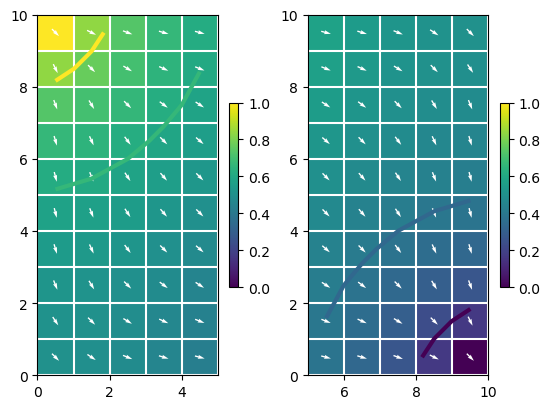

In [3]:
ws = './quickstart3'
name = 'mymodel'
sim = flopy.mf6.MFSimulation(sim_name=name, sim_ws=ws, exe_name='mf6')
tdis = flopy.mf6.ModflowTdis(sim)
ims = flopy.mf6.ModflowIms(sim, inner_dvclose=1.e-8)

# Left Model
name = "left"
nlay = 1
nrow = 10
ncol = 5
gwf = flopy.mf6.ModflowGwf(sim, modelname=name, save_flows=True)
dis = flopy.mf6.ModflowGwfdis(gwf, nrow=nrow, ncol=ncol)
ic = flopy.mf6.ModflowGwfic(gwf)
npf = flopy.mf6.ModflowGwfnpf(gwf, save_specific_discharge=True)
chd = flopy.mf6.ModflowGwfchd(gwf, stress_period_data=[[(0, 0, 0), 1.]],)
budget_file = name + '.bud'
head_file = name + '.hds'
oc = flopy.mf6.ModflowGwfoc(gwf,
                            budget_filerecord=budget_file,
                            head_filerecord=head_file,
                            saverecord=[('HEAD', 'ALL'), ('BUDGET', 'ALL')])
gwf_left = gwf

# Right Model
name = "right"
nlay = 1
nrow = 10
ncol = 5
gwf = flopy.mf6.ModflowGwf(sim, modelname=name, save_flows=True)
dis = flopy.mf6.ModflowGwfdis(gwf, nrow=nrow, ncol=ncol, xorigin=5)
ic = flopy.mf6.ModflowGwfic(gwf)
npf = flopy.mf6.ModflowGwfnpf(gwf, save_specific_discharge=True)
chd = flopy.mf6.ModflowGwfchd(gwf, stress_period_data=[[(0, nrow - 1, ncol - 1), 0.]])
budget_file = name + '.bud'
head_file = name + '.hds'
oc = flopy.mf6.ModflowGwfoc(gwf,
                            budget_filerecord=budget_file,
                            head_filerecord=head_file,
                            saverecord=[('HEAD', 'ALL'), ('BUDGET', 'ALL')])
gwf_right = gwf

delc = 1.
delr = 1.
exchangedata = []
for i in range(nrow):
    cid1 = (0, i, ncol-1)
    cid2 = (0, i, 0)
    ihc = 1
    cl1 = delc / 2.
    cl2 = delc / 2.
    hwva = delr
    angldegx = 0
    cdist = delc
    exchangedata.append([cid1, cid2, ihc, cl1, cl2, hwva, angldegx, cdist])
flopy.mf6.ModflowGwfgwf(sim, 
                        exgmnamea="left",
                        exgmnameb="right",
                        nexg=len(exchangedata),
                        auxiliary=["ANGLDEGX", "CDIST"],
                        exchangedata=exchangedata)

sim.write_simulation()
sim.run_simulation()

import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 2) 
for iplot, gwf in enumerate([gwf_left, gwf_right]):
    ax = axes[iplot]
    ax.set_aspect("equal")
    head = gwf.output.head().get_data()
    bud = gwf.output.budget()
    spdis = bud.get_data(text='DATA-SPDIS')[0]
    qx, qy, qz = flopy.utils.postprocessing.get_specific_discharge(spdis, gwf)

    pmv = flopy.plot.PlotMapView(gwf, ax=ax)
    c = pmv.plot_array(head, vmin=0, vmax=1)
    pmv.plot_grid(colors='white')
    pmv.contour_array(head, levels=[.2, .4, .6, .8], linewidths=3.)
    pmv.plot_vector(qx, qy, normalize=True, color="white")
    plt.colorbar(c, shrink=0.5)